# The Full Pipeline

**Inputs**: 
- scope 
- background image file path for 2159 scope
- experiment data
- config file
- timepoints (tp)
- number of UV bins

**Outputs**:
- droplets DataFrame (csv) 
- condensed DataFrame (csv)
- trimmed DataFrame (csv)
- heat maps

**Imports**:
- import python packages
- import kchip package depending on scope

Step 0: Average background images for 2159 scope

Step 1: Create droplets DataFrame
Compute and store:
- the RGB information of each droplet
- the cluster and cluster label of each droplet
- the location of each droplet
- the well ID of each droplet

Step 2: Create condensed DataFrame
- Loop through post-merge images and identify wells
- Map post-merge wells to pre-merge wells
- condense outputs to final dataframe

Step 3:
- filter droplets out based on barcode distances from cluster centroid
- filter dropelts out based on droplet area size
- check well locations
- check label counts

Step 4: 
- format output data for heatmap plotting
- get replicate counts for important combos
- get median, median tX-t0, and standard deviation values
- plot heatmaps


# Inputs (RUN FIRST)

In [1]:
# CHOOSE SCOPE
# 2159 = 0
# kyla = 1
scope = 0

## Data analysis inputs ##
# date of experiment
exp_date = "20211116_" 

# path to background images
input_folder = 'images/' 
# for generating bkgd images
bkg_num_images = 10
input_img_names = ['background'+str(n)+\
                   '.tif' for n in range(2,(bkg_num_images+1))]
# path for background image output
output_folder = input_folder
output_img_name = 'background_image.tif'


# config file
config_file = exp_date+'config.yml' 
# generates new folder for saving outputs
newfolder = exp_date+'output/' 
# number of timepoints to analyze
tp = 3
# number of UV bins for barcodes
UV_bins = ['_UV0'] #,'_UV10'] 

In [2]:
# Make output data folder
import os
os.makedirs(newfolder, exist_ok=True)

# Imports and config

In [3]:
# basic imports 
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from tqdm import tqdm_notebook as tqd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(1, '../../')
if scope == 0:
    # kchip imports
    import kchip_UV.io as kchip_io
    import kchip_UV.analyze as kchip_analyze
if scope == 1:
    # kchip imports
    import kchip_kyla.io as kchip_io
    import kchip_kyla.analyze as kchip_analyze
    
# Other
def rescale(arr):
    scaler = MinMaxScaler()
    scaler.fit(arr)
    return scaler.transform(arr)
%matplotlib inline

# Read in config file
with open(config_file, 'r') as ymlfile:
    config = yaml.load(ymlfile)
    
print (yaml.dump(config))

barcodes:
  cluster:
    eps: 0.03
    min_samples: 2
    offset:
    - 0
    - 0
    - 0
    points_to_cluster: 40000
  path: 20201109_Notes_UV0.xlsx
image:
  background_image: background_image
  base_path: images/
  bkg_img_suffix: _bg
  bugs: 3
  dyes:
  - 0
  - 1
  - 2
  names:
    premerge: 20211116_premerge
    t0: 20211116_t0
    t1: 20211116_t1
    t2: 20211116_t2
    t3: 20211116_t3
  overlap: 0.05
  pixel_size: 6.5
  rescale:
  - 1.2
  - 1.0
  - 1.0
  - 1
  size: 2048
  well_start_image:
  - 1
  - 2
  well_start_xy:
  - 540
  - 140
well_mask:
  filename: kchip/well_mask.tif
  pixel_size: 8.33625
  well_start_xy:
  - 850
  - 522



# Background Image (run for 2159 scope only)

In [4]:
# BACKGROUND IMAGE AVERAGING CELL

# Averages across multiple images (works for single images or stacks)
# Eg. to make background images
# Eg. to average foreground images
# Select settings
# Sigma is the sigma for the gaussian filter
# Use tuple for image stacks:
#     A 2048x2048 RYGBU imports as (2048, 2048, 5)
#     Use eg. sigma = (50,50,0) to filter in X and Y in each image, but not across channels
# For single images, use eg. sigma = (50,50) to filter in X and Y
sigma = (10,10,0)

# ---Begin code---

# Import packages
import numpy as np
from skimage import io
from os import path
import scipy.ndimage as ndimage
import tifffile

if scope == 0:
    # Create list to store image arrays in
    images = []

    # Import each image and apply gaussian filter
    # Add the smoothed image to the list
    for img in input_img_names:
        name = path.join(input_folder,img)
        img_ = io.imread(name)#[:4,:,:]
        img_ = ndimage.gaussian_filter(img_, sigma=sigma, order=0)
        images.append(img_)
        print(img_.shape)

    # Stack images from list to ndarray
    img_stack = np.stack(images)
    print(img_stack.shape)

    # Average the image values across the images
    img_ave = img_stack.mean(axis=0)
    print(img_ave.shape)

    # Convert the ndarray data to a convenient output data type and shape
    img16 = img_ave.astype('uint16')
    if img16.shape[1] > img16.shape[2]:
        img16trans = np.transpose(img16, (2,0,1))
        print('img16trans shape is: '+str(img16trans.shape))
    else:
        img16trans = img16

    print(img16.shape)

    # Output the new image to the specified location
    new_name = path.join(output_folder,output_img_name)
    if len(img16.shape) == 3:
        tifffile.imsave(new_name, img16trans, photometric='minisblack')
    else:
        tifffile.imsave(new_name, img16)

(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048, 4)
(9, 2048, 2048, 4)
(2048, 2048, 4)
img16trans shape is: (4, 2048, 2048)
(2048, 2048, 4)


# Create Droplets df
- Initialize from images
- Identify droplets in the same well from fit to masks
- Cluster
- Map apriori labels to clusters

In [5]:
from importlib import reload
reload(kchip_analyze)
# Initialize droplets DataFrame from images
droplets, rotation_theta = kchip_analyze.initialize_droplets(config)
# print 'Rotation (degrees): ', rotation_theta*180/np.pi

droplets.to_csv(newfolder+exp_date+'droplets_found.csv')

## Identify droplets in the same well from fit to masks
# droplets = kchip_analyze.fit_droplets_to_mask(config,droplets,rotation_theta)
# droplets.to_csv('droplets_assigned.csv')

Creating droplets from: 1,1
Found 4013 Droplets
Creating droplets from: 1,2
Found 5389 Droplets
Creating droplets from: 1,3
Found 5488 Droplets
Creating droplets from: 1,4
Found 5507 Droplets
Creating droplets from: 1,5
Found 5586 Droplets
Creating droplets from: 1,6
Found 5664 Droplets
Creating droplets from: 1,7
Found 5602 Droplets
Creating droplets from: 2,1
Found 5056 Droplets
Creating droplets from: 2,2
Found 5319 Droplets
Creating droplets from: 2,3
Found 5331 Droplets
Creating droplets from: 2,4
Found 5506 Droplets
Creating droplets from: 2,5
Found 5563 Droplets
Creating droplets from: 2,6
Found 5631 Droplets
Creating droplets from: 2,7
Found 5667 Droplets
Creating droplets from: 3,1
Found 4976 Droplets
Creating droplets from: 3,2
Found 5386 Droplets
Creating droplets from: 3,3
Found 5371 Droplets
Creating droplets from: 3,4
Found 5535 Droplets
Creating droplets from: 3,5
Found 5548 Droplets
Creating droplets from: 3,6
Found 5674 Droplets
Creating droplets from: 3,7
Found 5644 D

In [6]:
droplets.head()

IndexX  IndexY  ImageX  ImageY      Dye 0     Dye 1     Dye 2
0       1       1     633    2026   1597.296   6905.96   9454.76
1       1       1     807    1136  26026.752   2443.04    394.84
2       1       1     486     998   4175.088    829.04  13059.60
3       1       1    1011     998  17774.400   1968.20   4764.44
4       1       1     840    1016   5926.896  15843.04   1393.56

In [7]:
# From bchip libraries
# droplets = pd.read_csv("droplets_found_181219_chip1.csv",index_col=0)

from scipy.spatial.distance import pdist, squareform

def droplets_in_same_well(positions,close_threshold = 25):
    '''Identify droplets that are in the same well based on distance threshold
    Inputs:
    - Positions, (k x 2 ndarray), [x, y] positions of droplet centers
    - close_threshold, max distance between droplet centers to be considred in same well (default = 25)
    Outputs:
    - list of tuples (index 1, index 2) of indexes in positions of droplets in the same well
    '''

    pair_distances = squareform(pdist(positions))
    pair_distances[pair_distances==0]=float('inf')

    droplet1,droplet2 = np.where(pair_distances<close_threshold)
    zip_list = zip(droplet1,droplet2)

    # Sort list so small index is always first in tuple, and remove duplicates
    return list(set([tuple(sorted(tup_)) for tup_ in zip_list]))

def remove_overlap(config,df,show=0):
    ''' Remove droplets found in regions of image that overlap.
    Inputs:
        - config, config dictionary
        - df, pandas dataFrame
    Returns:
        - copy of dataframe, with dropped rows
    '''
    df = df.copy()
    maxX = df['IndexX'].max()
    maxY = df['IndexY'].max()
    
    overlap = config['image']['size']*(1-config['image']['overlap'])

    rmv_index = ((df['ImageX'] > overlap) & ~(df['IndexX']==maxX)) | ((df['ImageY'] > overlap) & ~(df['IndexY']==maxY))

    if show:
        print ('Removed: ' + str(np.sum(rmv_index)) + ' wells from dataFrame due to overlap in images.')

    return df.drop(df.index[rmv_index]).reset_index(drop=True)

In [8]:
# Remove overlap
droplets = remove_overlap(config,droplets,show=1)

unique_images = {tuple(row) for row in droplets[['IndexX','IndexY']].values}

droplets['Well_ID']=0
for x,y in unique_images:
    d = droplets.loc[(droplets['IndexX']==x) & (droplets['IndexY']==y)] 
    positions = d[['ImageX','ImageY']].values
    same_well = droplets_in_same_well(positions)
    
    well_id = np.zeros((d.shape[0],1))

    for i,dab in enumerate(same_well):
        d_a, d_b = dab
        well_id[d_a]=i
        well_id[d_b]=i

    droplets.loc[(droplets['IndexX']==x) & (droplets['IndexY']==y),'Well_ID']=well_id 
    
# Remove well_id = 0 
droplets = droplets[droplets['Well_ID']!=0]

# apply hash
droplets['Hash'] = droplets.apply(lambda row: hash((row['IndexX'],row['IndexY'],row['Well_ID'])),axis=1)

Removed: 27262 wells from dataFrame due to overlap in images.


In [9]:
droplets.head()

IndexX  IndexY  ImageX  ImageY      Dye 0     Dye 1     Dye 2  Well_ID  \
0       1       1     807    1136  26026.752   2443.04    394.84     15.0   
1       1       1     486     998   4175.088    829.04  13059.60   1500.0   
2       1       1    1011     998  17774.400   1968.20   4764.44   1194.0   
3       1       1     840    1016   5926.896  15843.04   1393.56   1501.0   
4       1       1    1012    1018  19354.512   5311.20   2578.40   1194.0   

                  Hash  
0  2528504235181315532  
1  2528504234194519029  
2  2528504233879955799  
3  2528504234195684078  
4  2528504233879955799

In [10]:
# Saves droplets assigned to wells and prints droplet count
droplets.to_csv(newfolder+exp_date+'droplets_wells_assigned.csv')
print ('all droplets',droplets.shape)

# Removes wells with only one droplet and saves wells with combos
# prints combo droplet count and df head
droplets = droplets[droplets.groupby('Hash').Hash.transform(len) > 1]
droplets.to_csv(newfolder+exp_date+'droplets_wells_assigned_combos.csv')
print ('combos only',droplets.shape)
droplets.head()

all droplets (281109, 9)
combos only (275268, 9)


IndexX  IndexY  ImageX  ImageY      Dye 0     Dye 1     Dye 2  Well_ID  \
0       1       1     807    1136  26026.752   2443.04    394.84     15.0   
1       1       1     486     998   4175.088    829.04  13059.60   1500.0   
2       1       1    1011     998  17774.400   1968.20   4764.44   1194.0   
3       1       1     840    1016   5926.896  15843.04   1393.56   1501.0   
4       1       1    1012    1018  19354.512   5311.20   2578.40   1194.0   

                  Hash  
0  2528504235181315532  
1  2528504234194519029  
2  2528504233879955799  
3  2528504234195684078  
4  2528504233879955799

In [11]:
# Corrects dye bleed through
droplets['Dye 1 corr']=droplets['Dye 1'].values-(0.02*droplets['Dye 2'].values)
droplets['Dye 2 corr']=droplets['Dye 2'].values-(0.14*droplets['Dye 1'].values)
droplets.to_csv(newfolder+exp_date+'droplets_dye_correction.csv')
droplets.head()

IndexX  IndexY  ImageX  ImageY      Dye 0     Dye 1     Dye 2  Well_ID  \
0       1       1     807    1136  26026.752   2443.04    394.84     15.0   
1       1       1     486     998   4175.088    829.04  13059.60   1500.0   
2       1       1    1011     998  17774.400   1968.20   4764.44   1194.0   
3       1       1     840    1016   5926.896  15843.04   1393.56   1501.0   
4       1       1    1012    1018  19354.512   5311.20   2578.40   1194.0   

                  Hash  Dye 1 corr  Dye 2 corr  
0  2528504235181315532   2435.1432     52.8144  
1  2528504234194519029    567.8480  12943.5344  
2  2528504233879955799   1872.9112   4488.8920  
3  2528504234195684078  15815.1688   -824.4656  
4  2528504233879955799   5259.6320   1834.8320

# Go to Interactive Clustering

In [12]:
UV0 = pd.read_csv(newfolder+exp_date+'droplets_clustered_corrected_UV0.csv', index_col=0)
# UV10 = pd.read_csv(newfolder+exp_date+'droplets_clustered_corrected_UV10.csv', index_col=0)
droplets = UV0

In [13]:
print('# Labels/droplet groups',len(droplets.Label.unique()))

# Labels/droplet groups 112


In [14]:
droplets.to_csv(newfolder+exp_date+'droplets_clustered_corrected_all.csv')

In [15]:
print(pd.__version__)


1.0.1


# Creates Condensed df
- Create pre-merge wells dataFrame
- Loop through post-merge images and identify wells
- Map post-merge wells to pre-merge wells

In [16]:
# If reading in csv file:
droplets = pd.read_csv(newfolder+exp_date+'droplets_clustered_corrected_all.csv',index_col=0)

# Identify premerge wells
pre_wells = droplets.groupby(['IndexX','IndexY','Well_ID'],as_index=False)[['ImageX','ImageY']].mean()
print(pre_wells)

# List of timepoints
timepoints = ['t'+str(i) for i in range(3)]
print(timepoints)

# Analyze data for each timepoint
pre_post_all = []
for timepoint in timepoints:
    print ('Now analyzing timepoint: ', timepoint)
    # Identify postmerge wells and map to pre-merge wells
    pre_post_all.append(kchip_analyze.map_pre_to_post(config,timepoint,pre_wells))
   
# Condense output
condensed = kchip_analyze.stack_timepoints(droplets,pre_post_all,timepoints)
# Pre_post output
pre_post = pd.DataFrame(pre_post_all[0]) 

        IndexX  IndexY  Well_ID  ImageX  ImageY
0            1       1      1.0  1248.0  1351.5
1            1       1      2.0  1454.0   397.5
2            1       1      4.0   865.0  1621.5
3            1       1      5.0  1662.5  1785.0
4            1       1      6.0  1395.0  1374.5
...        ...     ...      ...     ...     ...
137629       9       7   2784.0  1693.5   649.0
137630       9       7   2785.0   990.5  1527.5
137631       9       7   2786.0  1698.0   942.5
137632       9       7   2787.0   692.5   502.5
137633       9       7   2788.0  1315.5  1066.0

[137634 rows x 5 columns]
['t0', 't1', 't2']
Now analyzing timepoint:  t0
Now analyzing: 1,1
Now analyzing: 1,2
Now analyzing: 1,3
Now analyzing: 1,4
Now analyzing: 1,5
Now analyzing: 1,6
Now analyzing: 1,7
Now analyzing: 2,1
Now analyzing: 2,2
Now analyzing: 2,3
Now analyzing: 2,4
Now analyzing: 2,5
Now analyzing: 2,6
Now analyzing: 2,7
Now analyzing: 3,1
Now analyzing: 3,2
Now analyzing: 3,3
Now analyzing: 3,4
Now ana

In [17]:
# Save outputs
pre_post.to_csv(newfolder+exp_date+'pre_post.csv')
condensed.to_csv(newfolder+exp_date+'condensed_output.csv')

# Images Analyzed, Load in Data

In [18]:
# Read in droplets and condensed
droplets = pd.read_csv(newfolder+exp_date+'droplets_clustered_corrected_all.csv',\
                       index_col=0)
pre_post = pd.read_csv(newfolder+exp_date+'pre_post.csv',index_col=0)
condensed = pd.read_csv(newfolder+exp_date+'condensed_output.csv', index_col=0)

# droplets2 = pd.read_csv(newfolder+exp_date+'droplets_clustered_corrected_all_2.csv',\
#                        index_col=0)
# pre_post2 = pd.read_csv(newfolder+exp_date+'pre_post_2.csv',index_col=0)
# condensed2 = pd.read_csv(newfolder+exp_date+'condensed_output_2.csv', index_col=0)

# droplets = pd.concat([droplets,droplets2], axis=0, ignore_index=True)
# condensed = pd.concat([condensed,condensed2], axis=0, ignore_index=True)
# pre_post = pd.concat([pre_post,pre_post2], axis=0, ignore_index=True)

# Quality Control (filtering)

In [19]:
# Gets all guides and targets from notes file
all_labels = []
for i in UV_bins:
    Notes_path = '20211116_Notes'+i+'.xlsx'
    labels = pd.read_excel(Notes_path,'Labels',index_col=0).fillna(u'BLANK')
    labels_list = []
    for i in range(len(labels.index)):
        for j in range(len(labels.columns)):
            x = labels.iloc[i,j]
            if x != u'BLANK':
                labels_list.append(x)
    all_labels.append(labels_list) 
all_labels = [item for items in all_labels for item in items]
guides = [x for x in all_labels if x.startswith("c")] 
targets = [x for x in all_labels if x.startswith("T")] 
targets = sorted(targets, key = lambda x: int(x.split('T')[1]))
guides = sorted(guides, key = lambda x: int(x.split('A')[1]))

In [20]:
# Pull out guides and targets from the droplets dataframe:
guides_only = droplets[droplets['Label'].isin(guides)]
targets_only = droplets[droplets['Label'].isin(targets)]

# Merge condensed with the guides and then targets:
with_guides = condensed.merge(guides_only,on=['Hash'],how='outer')
with_both = with_guides.merge(targets_only,on=['Hash'],how='outer',suffixes=('_left','_right'))

# Remove any rows with NaN:
trimmed = with_both.dropna()

In [13]:
trimmed.head()

Hash   T1  T10  T11  T12  T13  T14  T15  T16  T17  ...  \
1   2528504235175490287  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4   2528504235173160189  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...   
11  2528504235187140777  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
20  2528504235183645630  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
23  2528504235181315532  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

    Dye 1_right  Dye 2_right  Well_ID_right  Dye 1 corr_right  \
1      12868.00     64963.00            2.0        11568.7400   
4      28117.48     34230.36            4.0        27432.8728   
11     53666.84     43826.56            8.0        52790.3088   
20     44960.36     31523.04           13.0        44329.8992   
23     51549.48     55857.48           15.0        50432.3304   

    Dye 2 corr_right  PlaneX_right  PlaneY_right  Cluster_right  Label_right  \
1         63161.4800      0.024138      0.499116           35.0           T7   
4         30293.9128      0.244149     -0.114836           36.0          T16   
11        36313.2024      0.501758     -0.231346           12.0           T4   
20        25228.5896      0.470472     -0.348521           39.0           T6   
23        48640.5528      0.497781     -0.025413            9.0           T2   

                                        Barcode_right  
1   [38.23529411764706, 5.882352941176471, 5.88235...  
4   [20.58823529411765, 20.58823529411765, 8.82352...  
11  [17.647058823529413, 29.411764705882355, 2.941...  
20  [14.705882352941178, 29.411764705882355, 5.882...  
23       [23.529411764705884, 26.47058823529412, 0.0]  

[5 rows x 87 columns]

In [21]:
# Calculates centroids and barcode distances
trimmed['CentroidX_left'] = trimmed.groupby('Label_left')['PlaneX_left'].transform('median')
trimmed['CentroidY_left'] = trimmed.groupby('Label_left')['PlaneY_left'].transform('median')
trimmed['distance_left'] = np.sqrt((trimmed.PlaneX_left-trimmed.CentroidX_left)**2\
                                   +(trimmed.PlaneY_left-trimmed.CentroidY_left)**2)

trimmed['CentroidX_right'] = trimmed.groupby('Label_right')['PlaneX_right'].transform('median')
trimmed['CentroidY_right'] = trimmed.groupby('Label_right')['PlaneY_right'].transform('median')
trimmed['distance_right'] = np.sqrt((trimmed.PlaneX_right-trimmed.CentroidX_right)**2\
                                    +(trimmed.PlaneY_right-trimmed.CentroidY_right)**2)

In [22]:
# renames columns
trimmed = trimmed.rename(columns = {'Dye 0_left':'Dye0_left', \
                                    'Dye 1_left':'Dye1_left', \
                                    'Dye 2_left':'Dye2_left', \
                                    'Dye 0_right':'Dye0_right',\
                                    'Dye 1_right':'Dye1_right',\
                                    'Dye 2_right':'Dye2_right'})

In [23]:
# normalized reporter signal
trimmed['summed']=(trimmed.Dye0_left+trimmed.Dye1_left+trimmed.Dye2_left+\
                   trimmed.Dye0_right+trimmed.Dye1_right+trimmed.Dye2_right)
med = trimmed.summed.median()
trimmed['ratio']=trimmed.summed/med
trimmed['t0_norm2']=trimmed.t0/trimmed.ratio
trimmed['t1_norm2']=trimmed.t1/trimmed.ratio
trimmed['t2_norm2']=trimmed.t2/trimmed.ratio
# trimmed['t3_norm2']=trimmed.t3/trimmed.ratio

## Distance and Area Filtering

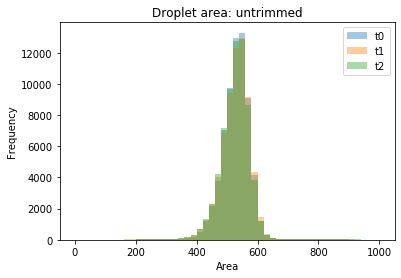

In [24]:
plt.hist(trimmed['t0_Area'],bins=50,range=(0,1000), label = 't0', alpha=0.4)
plt.hist(trimmed['t1_Area'],bins=50,range=(0,1000), label = 't1', alpha=0.4)
plt.hist(trimmed['t2_Area'],bins=50,range=(0,1000), label = 't2', alpha=0.4)
# plt.hist(trimmed['t3_Area'],bins=50,range=(0,1000), label = 't3', alpha=0.4)
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Droplet area: untrimmed')
# plt.xlim(450,650)
plt.legend()
plt.show()

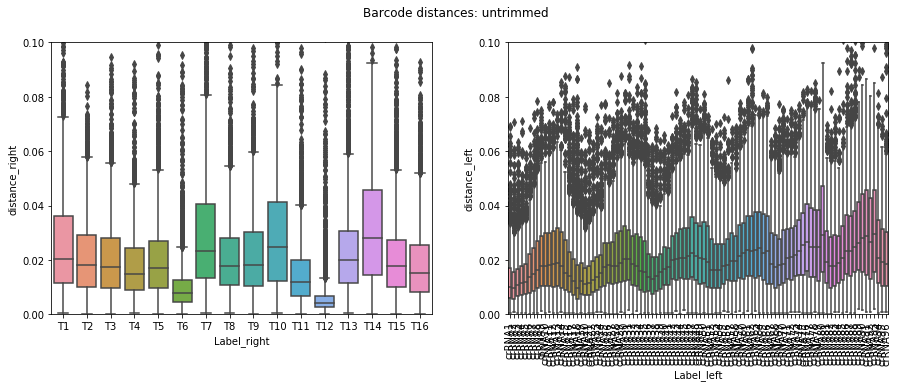

In [25]:
# To test barcode distances:
Ldist = trimmed[['Label_left','distance_left']]
Lcolumn_order = guides
Rdist = trimmed[['Label_right','distance_right']]
Rcolumn_order = targets

f, axes = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(x='Label_left',y='distance_left',data=Ldist,order=Lcolumn_order, ax=axes[1])
sns.boxplot(x='Label_right',y='distance_right',data=Rdist,order=Rcolumn_order, ax=axes[0])
plt.xticks(rotation=90)
ylim = [0.0,0.10]
plt.setp(axes, ylim=ylim)
f.suptitle('Barcode distances: untrimmed')
plt.show()

In [26]:
Ldistance_trimmed = trimmed[trimmed['distance_left']<0.05]
distance_trimmed = Ldistance_trimmed[Ldistance_trimmed['distance_right']<0.05]
print("barcode untrimmed",trimmed.shape)
print("barcode trimmed",distance_trimmed.shape)

barcode untrimmed (66855, 161)
barcode trimmed (57883, 161)


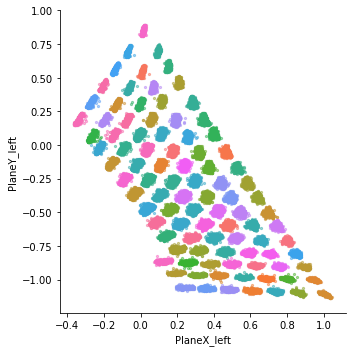

In [27]:
g = sns.FacetGrid(distance_trimmed, hue="Label_left", size=5)
g.map(plt.scatter, "PlaneX_left", "PlaneY_left", s=5, alpha=.5)
# g.add_legend();

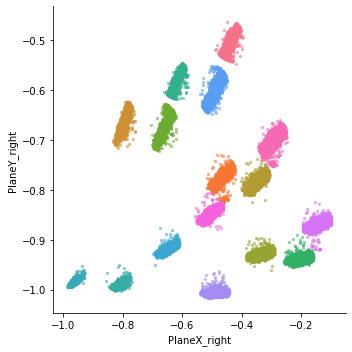

In [28]:
f = sns.FacetGrid(distance_trimmed, hue="Label_right", size=5)
f.map(plt.scatter, "PlaneX_right", "PlaneY_right", s=5, alpha=.5)
# f.add_legend();

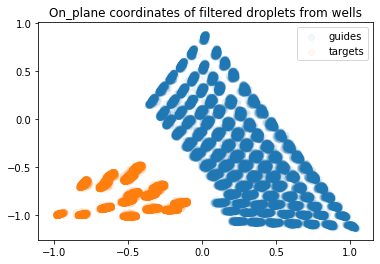

In [29]:
# Plots droplets onto the triangle, filtered
plt.scatter(distance_trimmed['PlaneX_left'],distance_trimmed['PlaneY_left'],alpha=0.05, label = 'guides')
plt.scatter(distance_trimmed['PlaneX_right'],distance_trimmed['PlaneY_right'],alpha=0.05, label = 'targets')
plt.gca().set_title('On_plane coordinates of filtered droplets from wells')
plt.legend()

In [30]:
d_area_trimmed = distance_trimmed[distance_trimmed['t0_Area']<800]
d_area_trimmed = d_area_trimmed[d_area_trimmed['t0_Area']>200]
print("aread trimmed",d_area_trimmed.shape)

aread trimmed (57816, 161)


In [31]:
d_area_trimmed.to_csv(newfolder+exp_date+'distance_and_area_filtered.csv')

## Well Locations

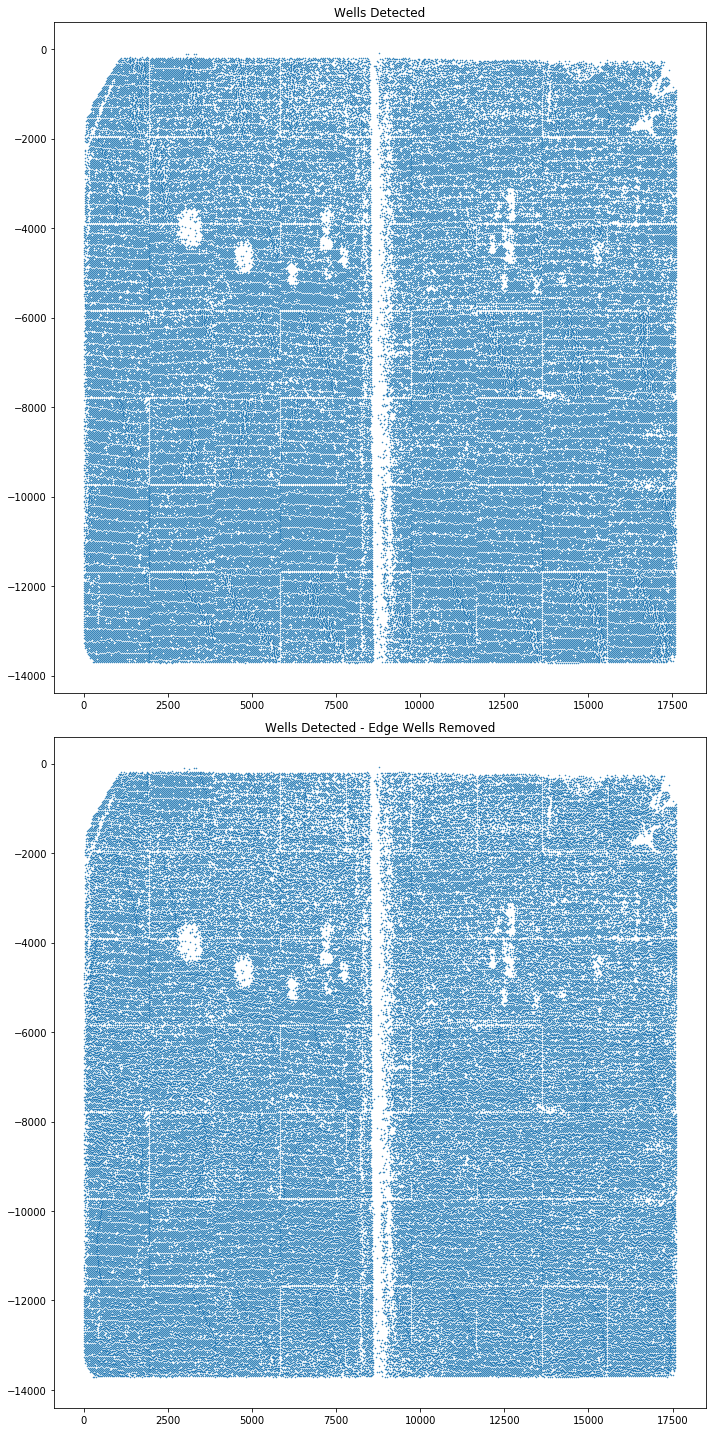

In [32]:
# Plot locations of all identified droplets on 2D plane to represent the chip
# Can identify portion of chip where droplet identification failed
# Regions may due to cross merging
fig, axes = plt.subplots(2,1,figsize=(10,20))

axes[0].plot(pre_post['Pre_GlobalX'],-pre_post['Pre_GlobalY'],'.',ms=1)
axes[0].set_title('Wells Detected')
# axes[0].set_axis_off()

axes[1].plot(pre_post['Post_GlobalX'],-pre_post['Post_GlobalY'],'.',ms=1)
axes[1].set_title('Wells Detected - Edge Wells Removed')
# axes[1].set_axis_off()

plt.tight_layout()

## Label Counts

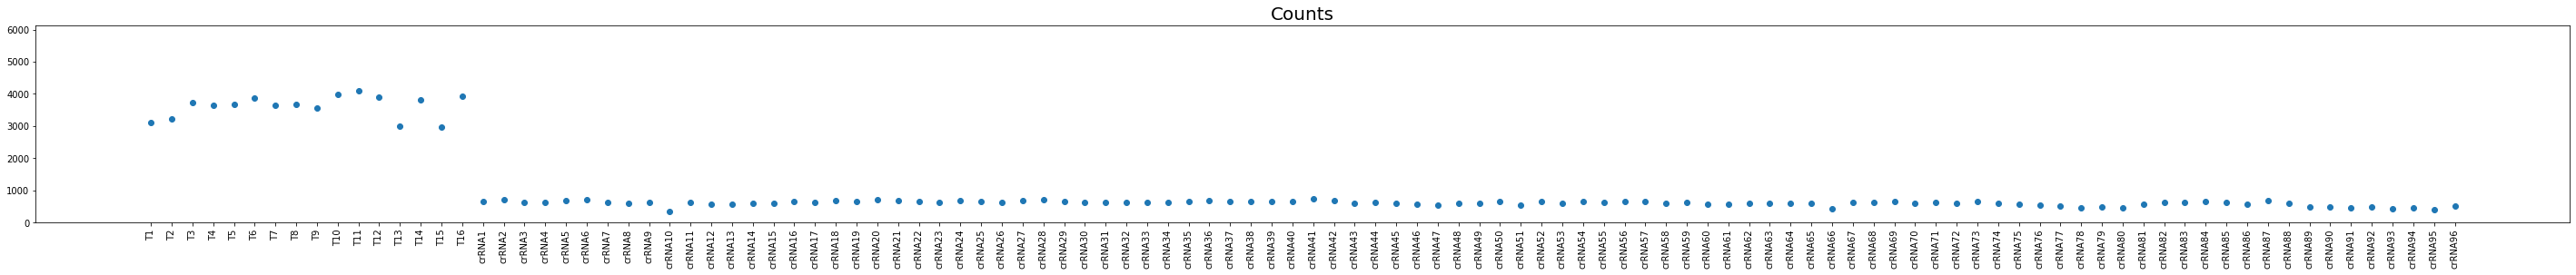

In [33]:
labels = targets+guides
counts = d_area_trimmed.sum()[labels]
# print(counts)

fig, axes = plt.subplots(1,1,figsize=(50,4))
axes.plot(counts.values,'o')
axes.set_xticks(range(len(counts.index.values)))
axes.set_xticklabels(counts.index.values,size=10,rotation=90)
plt.ylim(0, 1.5*max(counts))
axes.set_title('Counts',size=20)
plt.savefig(newfolder+exp_date+'Label_counts.png',bbox_inches='tight',dpi=300)

# Data Analysis

In [34]:
condensed = pd.read_csv(newfolder+exp_date+'distance_and_area_filtered.csv',index_col=0)

In [35]:
condensed.shape

(57816, 161)

In [36]:
condensed.head()

Hash   T1  T10  T11  T12  T13  T14  T15  T16   T2  ...  \
0  2528504235178985434  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   
1  2528504235175490287  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2  2528504235173160189  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3  2528504235174325238  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
6  2528504235171995140  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

   CentroidY_left  distance_left  CentroidX_right  CentroidY_right  \
0       -0.897339       0.004944        -0.443854        -0.508733   
1       -0.714763       0.021296        -0.470501        -0.776765   
2       -0.043138       0.030109        -0.803544        -0.668550   
3       -0.596021       0.034668        -0.354890        -0.784367   
6        0.547585       0.028462        -0.803544        -0.668550   

   distance_right     summed     ratio   t0_norm2   t1_norm2   t2_norm2  
0        0.026119  44967.792  1.206204  25.512628  17.048400  18.617226  
1        0.039533  63130.856  1.693405  23.475981  26.292470  27.101740  
2        0.014401  40779.512  1.093859  24.822053  17.595893  18.015126  
3        0.047165  33479.384  0.898042  28.477588  22.696500  25.432472  
6        0.039514  42218.920  1.132469  31.109142  31.656492  31.760113  

[5 rows x 161 columns]

In [37]:
targets = list(set(condensed['Label_right']))
targets = sorted(targets, key = lambda x: int(x.split('T')[1]))
guides = list(set(condensed['Label_left']))
guides = sorted(guides, key = lambda x: int(x.split('A')[1]))
figures_folder = exp_date+'figures/'
exp_string = exp_date

In [38]:
# make output folder
import os
os.makedirs(figures_folder, exist_ok=True)

In [39]:
# reads in plate map to map sabeti sample names to blainey sample names
map_path = exp_date+'PlateMap.xlsx'
sabeti_labels = pd.read_excel(map_path)
xl = pd.ExcelFile(map_path)
nrows = xl.book.sheet_by_index(0).nrows
platetables = int((nrows+1)/10)

s_names = []
b_names = []
for i in range(platetables):
    df_s = xl.parse(0,index_col=0,skiprows=10*i,\
                     skipfooter=nrows-9-i*10).dropna(axis=1, how='all')
    s_names.append(df_s.values.tolist())
    df_b = xl.parse(1,index_col=0,skiprows=10*i,\
                     skipfooter= nrows-9-i*10).dropna(axis=1, how='all')
    b_names.append(df_b.values.tolist())
# flattens lists
s_names = [item for items in s_names for item in items]
s_names = [item for items in s_names for item in items]
b_names = [item for items in b_names for item in items]
b_names = [item for items in b_names for item in items]
# makes elements into strings
s_string = [str(i) for i in s_names]
b_string = [str(i) for i in b_names]
# drop nan values
clean_s = [x for x in s_string if str(x) != 'nan']
clean_b = [x for x in b_string if str(x) != 'nan']
# creates mapping dictionary
mapping = {clean_b[i]: clean_s[i] for i in range(len(clean_b))}

In [40]:
# for count of replicate numbers
num_fl = pd.DataFrame(0, index=guides, columns=targets)
# for medians and standard deviations of tX signal
median_t0 = pd.DataFrame(0, index=guides, columns=targets)
cv_t0 = pd.DataFrame(0, index=guides, columns=targets)
stdev_t0 = pd.DataFrame(0, index=guides, columns=targets)
median_t1 = pd.DataFrame(0, index=guides, columns=targets)
cv_t1 = pd.DataFrame(0, index=guides, columns=targets)
stdev_t1 = pd.DataFrame(0, index=guides, columns=targets)
median_t2 = pd.DataFrame(0, index=guides, columns=targets)
cv_t2 = pd.DataFrame(0, index=guides, columns=targets)
stdev_t2 = pd.DataFrame(0, index=guides, columns=targets)
median_t3 = pd.DataFrame(0, index=guides, columns=targets)
cv_t3 = pd.DataFrame(0, index=guides, columns=targets)
stdev_t3 = pd.DataFrame(0, index=guides, columns=targets)
# for pvalues
stat_pval_t0 = pd.DataFrame(float(0), index=guides, columns=targets)
stat_pval_t1 = pd.DataFrame(float(0), index=guides, columns=targets)
stat_pval_t2 = pd.DataFrame(float(0), index=guides, columns=targets)
stat_pval_t3 = pd.DataFrame(float(0), index=guides, columns=targets)
# template for mapping controls


In [41]:
# Loop through detection mixes and targets
from scipy.stats import variation
tgt_water = list(mapping.keys())[list(mapping.values()).index('128x_ntc')]

for guide in guides:
    for target in targets:
        groups = condensed.groupby([guide, target])[['t0_norm2', 't1_norm2', 't2_norm2']].groups
        if (1,1) in groups:
#         Get t0 and t1 values from the group of wells that have 1 droplet each of the current detection mix and target:
#         print curr_dm, curr_tgt
#             print(guide, target, 'found')
#             tgt_pc = pc_mapping[guide]
#             tgt_nc = nc_mapping[guide]
            curr_pair = condensed.groupby([guide, target])[['t0_norm2',\
                                                            't1_norm2', 't2_norm2']].get_group((1,1))
            water_pair = condensed.groupby([guide,tgt_water])[['t0_norm2',\
                                                                 't1_norm2', 't2_norm2']].get_group((1,1))
#             pc_pair = condensed.groupby([guide,tgt_pc])[['t0_norm2',\
#                                                                  't1_norm2','t2_norm2']].get_group((1,1))
#             nc_pair = condensed.groupby([guide,tgt_nc])[['t0_norm2',\
#                                                                  't1_norm2','t2_norm2']].get_group((1,1))
            nc_pair = water_pair
# Subtract each t0 value from each t1 value, removing "NaN" values
# "NaN" values arise when there is a missing t1 value = the droplet wasn't 
# found in the t1 images

            median_t0.loc[guide, target] = curr_pair['t0_norm2'].median()
            cv_t0.loc[guide, target] = variation(curr_pair['t0_norm2'])
            stdev_t0.loc[guide, target] = curr_pair['t0_norm2'].std()
            
            median_t1.loc[guide, target] = curr_pair['t1_norm2'].median()
            cv_t1.loc[guide, target] = variation(curr_pair['t1_norm2'])
            stdev_t1.loc[guide, target] = curr_pair['t1_norm2'].std()
            
            median_t2.loc[guide, target] = curr_pair['t2_norm2'].median()
            cv_t2.loc[guide, target] = variation(curr_pair['t2_norm2'])
            stdev_t2.loc[guide, target] = curr_pair['t2_norm2'].std()
            
#             median_t3.loc[guide, target] = curr_pair['t3_norm2'].median()
#             cv_t3.loc[guide, target] = variation(curr_pair['t3_norm2'])
#             stdev_t3.loc[guide, target] = curr_pair['t3_norm2'].std()

# Count the number of wells in the group, and store the 
# value in the num_fl dataframe
            num_fl.loc[guide, target] = curr_pair.shape[0]
    
            if curr_pair.shape[0]<3:
                median_t0.loc[guide, target] = np.nan
                median_t1.loc[guide, target] = np.nan
                median_t2.loc[guide, target] = np.nan
#                 median_t3.loc[guide, target] = np.nan

#At each time point, compare distribution of given guide-target pair against guide-water pair
            st, pval = stats.mannwhitneyu(curr_pair.t0_norm2, nc_pair.t0_norm2, alternative='greater')
            stat_pval_t0.at[guide,target] = -np.log10(pval)
            st, pval = stats.mannwhitneyu(curr_pair.t1_norm2, nc_pair.t1_norm2, alternative='greater')
            stat_pval_t1.at[guide,target] = -np.log10(pval)
            st, pval = stats.mannwhitneyu(curr_pair.t2_norm2, nc_pair.t2_norm2, alternative='greater')
            stat_pval_t2.at[guide,target] = -np.log10(pval)
#             st, pval = stats.mannwhitneyu(curr_pair.t3_norm2, nc_pair.t3_norm2, alternative='greater')
#             stat_pval_t3.at[guide,target] = -np.log10(pval)
        else:
            print(guide, target, 'not found')
            num_fl.loc[guide, target] = 0

In [42]:
# saving counts df
num_fl.to_csv(newfolder+exp_date+'target_guide_combo_count.csv')
# saving medians and standard deviations of tX signal df
median_t0.to_csv(newfolder+exp_date+'median_t0.csv')
cv_t0.to_csv(newfolder+exp_date+'cv_t0.csv')
stdev_t0.to_csv(newfolder+exp_date+'stdev_t0.csv')

median_t1.to_csv(newfolder+exp_date+'median_t1.csv')
cv_t1.to_csv(newfolder+exp_date+'cv_t1.csv')
stdev_t1.to_csv(newfolder+exp_date+'stdev_t1.csv')

median_t2.to_csv(newfolder+exp_date+'median_t2.csv')
cv_t2.to_csv(newfolder+exp_date+'cv_t2.csv')
stdev_t2.to_csv(newfolder+exp_date+'stdev_t2.csv')

median_t3.to_csv(newfolder+exp_date+'median_t3.csv')
cv_t3.to_csv(newfolder+exp_date+'cv_t3.csv')
stdev_t3.to_csv(newfolder+exp_date+'stdev_t3.csv')

# saving pvalues from Mann-Whitney U test
stat_pval_t0.to_csv(newfolder+exp_date+'pval_stat_t0.csv')
stat_pval_t1.to_csv(newfolder+exp_date+'pval_stat_t1.csv')
stat_pval_t2.to_csv(newfolder+exp_date+'pval_stat_t2.csv')
stat_pval_t3.to_csv(newfolder+exp_date+'pval_stat_t3.csv')

In [43]:
condensed.Label_right.replace(mapping)
condensed.Label_left.replace(mapping)
condensed.to_csv(newfolder+exp_date+'condensed_filtered_labeled.csv')
condensed.head()

Hash   T1  T10  T11  T12  T13  T14  T15  T16   T2  ...  \
0  2528504235178985434  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   
1  2528504235175490287  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2  2528504235173160189  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3  2528504235174325238  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
6  2528504235171995140  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

   CentroidY_left  distance_left  CentroidX_right  CentroidY_right  \
0       -0.897339       0.004944        -0.443854        -0.508733   
1       -0.714763       0.021296        -0.470501        -0.776765   
2       -0.043138       0.030109        -0.803544        -0.668550   
3       -0.596021       0.034668        -0.354890        -0.784367   
6        0.547585       0.028462        -0.803544        -0.668550   

   distance_right     summed     ratio   t0_norm2   t1_norm2   t2_norm2  
0        0.026119  44967.792  1.206204  25.512628  17.048400  18.617226  
1        0.039533  63130.856  1.693405  23.475981  26.292470  27.101740  
2        0.014401  40779.512  1.093859  24.822053  17.595893  18.015126  
3        0.047165  33479.384  0.898042  28.477588  22.696500  25.432472  
6        0.039514  42218.920  1.132469  31.109142  31.656492  31.760113  

[5 rows x 161 columns]

In [44]:
# reads in counts df
num_fl = pd.read_csv(newfolder+exp_date+'target_guide_combo_count.csv',index_col=0)
# reads in medians and standard deviations of tX signal df
median_t0 = pd.read_csv(newfolder+exp_date+'median_t0.csv',index_col=0)
cv_t0 = pd.read_csv(newfolder+exp_date+'cv_t0.csv',index_col=0)
stdev_t0 = pd.read_csv(newfolder+exp_date+'stdev_t0.csv',index_col=0)

median_t1 = pd.read_csv(newfolder+exp_date+'median_t1.csv',index_col=0)
cv_t1 = pd.read_csv(newfolder+exp_date+'cv_t1.csv',index_col=0)
stdev_t1 = pd.read_csv(newfolder+exp_date+'stdev_t1.csv',index_col=0)

median_t2 = pd.read_csv(newfolder+exp_date+'median_t2.csv',index_col=0)
cv_t2 = pd.read_csv(newfolder+exp_date+'cv_t2.csv',index_col=0)
stdev_t2 = pd.read_csv(newfolder+exp_date+'stdev_t2.csv',index_col=0)

median_t3 = pd.read_csv(newfolder+exp_date+'median_t3.csv',index_col=0)
cv_t3 = pd.read_csv(newfolder+exp_date+'cv_t3.csv',index_col=0)
stdev_t3 = pd.read_csv(newfolder+exp_date+'stdev_t3.csv',index_col=0)

# reads in pvalues from Mann-Whitney U test
stat_pval_t0 = pd.read_csv(newfolder+exp_date+'pval_stat_t0.csv',index_col=0)
stat_pval_t1 = pd.read_csv(newfolder+exp_date+'pval_stat_t1.csv',index_col=0)
stat_pval_t2 = pd.read_csv(newfolder+exp_date+'pval_stat_t2.csv',index_col=0)
stat_pval_t3 = pd.read_csv(newfolder+exp_date+'pval_stat_t3.csv',index_col=0)

In [45]:
def plot_heatmap(data,exp_string,title_string,annot = 0):
    data_m1 = data.rename(index=mapping)
    data_m = data_m1.rename(columns=mapping)
#     data_m = data_m.sort_index(axis=0)
    %config InlineBackend.figure_format = 'svg'
    tgt_num = len(data_m.columns)
    gd_num = len(data_m.index)
    fig, axes = plt.subplots(1,1, figsize=(tgt_num*.22,gd_num*.22))
    plt.xlabel('Targets', size = 10)
    plt.ylabel('Detection Mixes', size = 10)
    plt.title(exp_string+title_string, size = 12)
    if annot == 1:
        sns.heatmap(data_m, annot=True, fmt = "0.0f",\
            annot_kws={"size": 6}, linewidths = 0.2, \
            square = False, cmap = 'Blues', cbar = True, \
            xticklabels=True, cbar_kws={'pad':0.002})
    else:
        sns.heatmap(data_m, annot=False, fmt = "0.0f",\
            linewidths = 0, square = False, \
            cmap = 'Blues',cbar = True, \
            xticklabels=True,cbar_kws={'pad':0.002})      
    plt.yticks(rotation=0) 
    h_lines = np.arange(3,gd_num,3)
    v_lines = np.arange(3,tgt_num,3)
    axes.hlines(h_lines, colors = 'silver',alpha=0.9,linewidths = 0.35,*axes.get_xlim())
    axes.vlines(v_lines, colors = 'silver',alpha=0.9,linewidths = 0.35,*axes.get_ylim())
    plt.savefig(figures_folder+exp_string+title_string+'.png',\
                dpi=300, bbox_inches='tight')

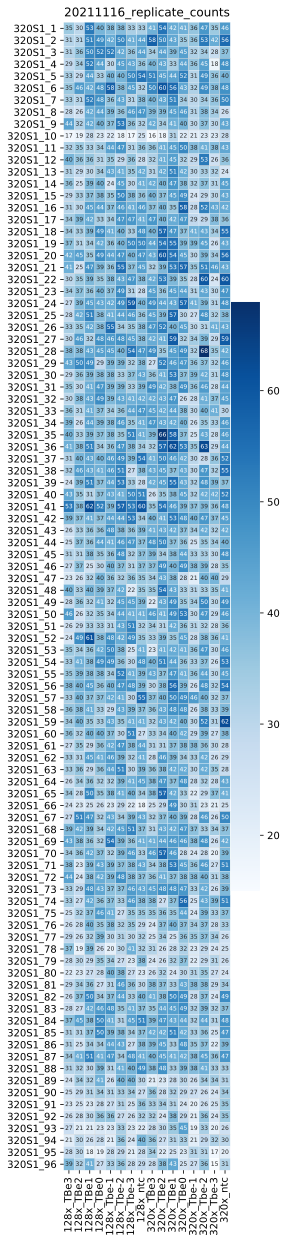

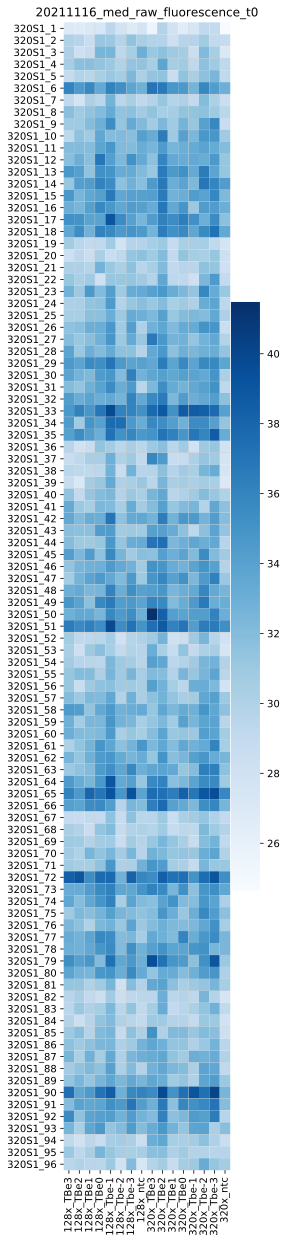

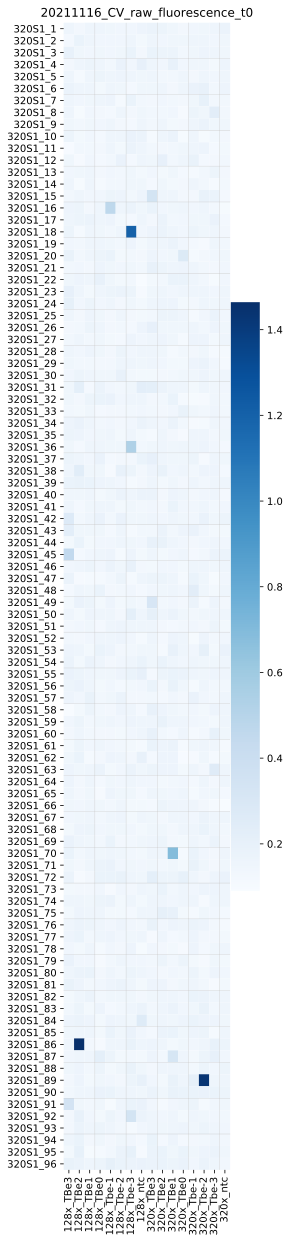

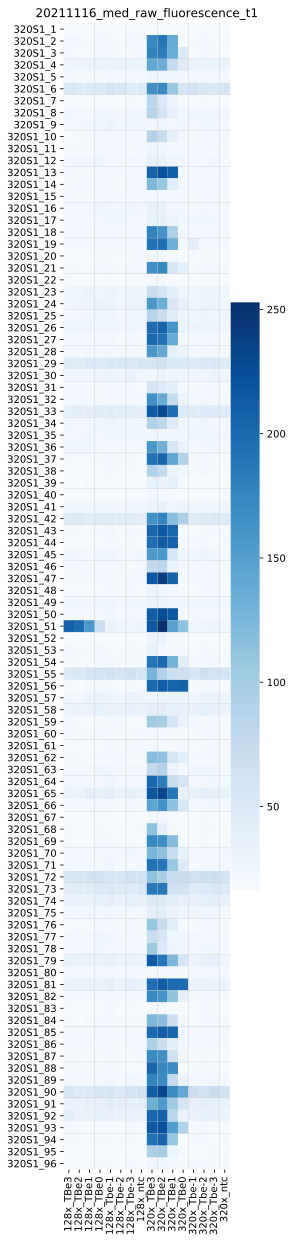

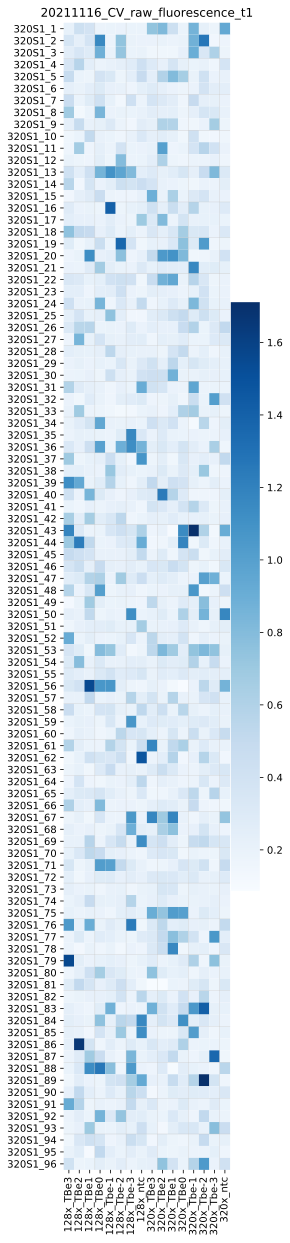

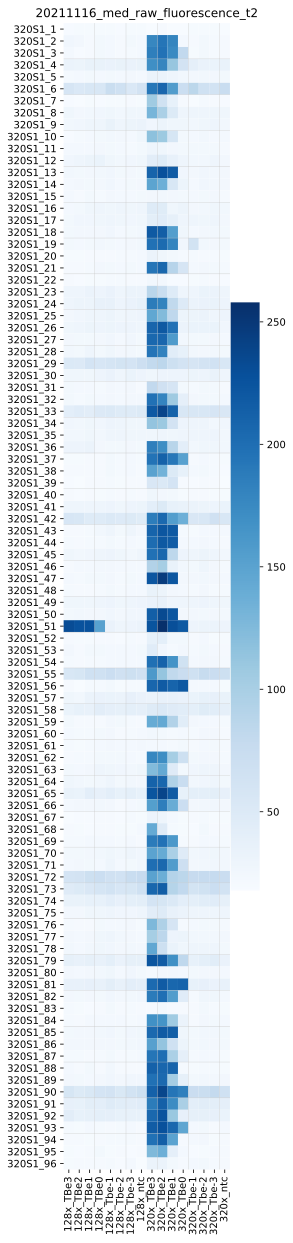

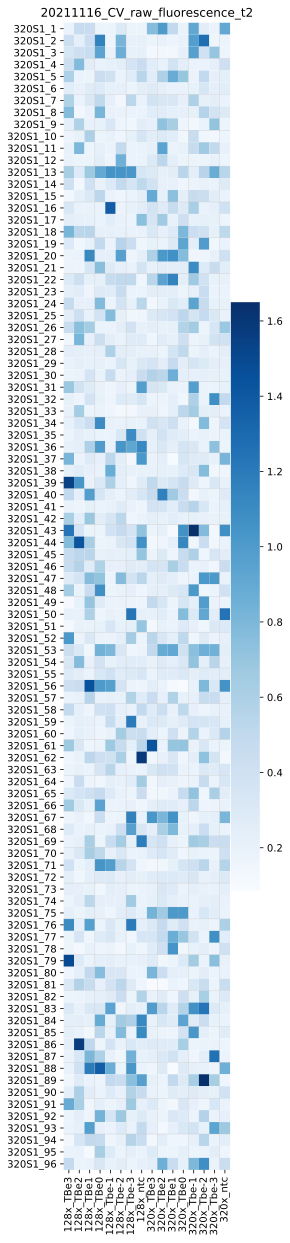

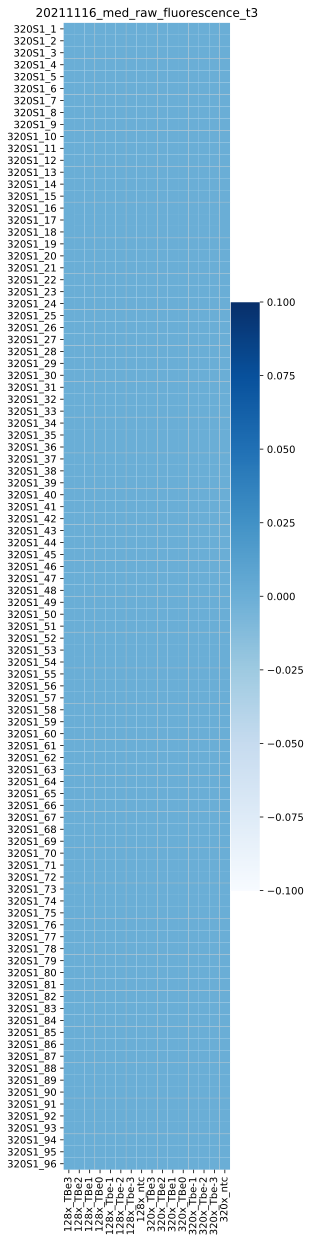

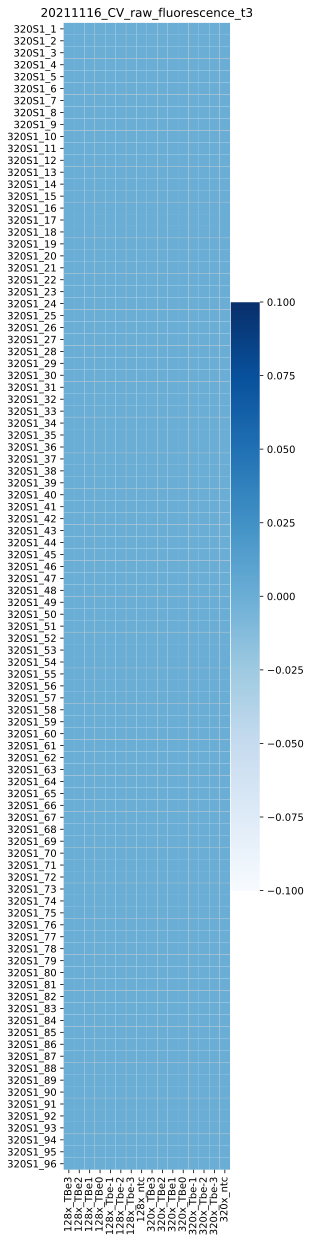

In [46]:
exp_string = exp_date
dfs = [num_fl, median_t0, cv_t0,\
       median_t1, cv_t1, median_t2,cv_t2, median_t3, cv_t3]
titles = ['replicate_counts','med_raw_fluorescence_t0','CV_raw_fluorescence_t0',\
         'med_raw_fluorescence_t1','CV_raw_fluorescence_t1','med_raw_fluorescence_t2','CV_raw_fluorescence_t2', 'med_raw_fluorescence_t3','CV_raw_fluorescence_t3']
annot = [1,0,0,\
       0,0,0,0,0,0]
for i in range(len(dfs)):
    plot_heatmap(dfs[i],exp_string,titles[i],annot[i]) 

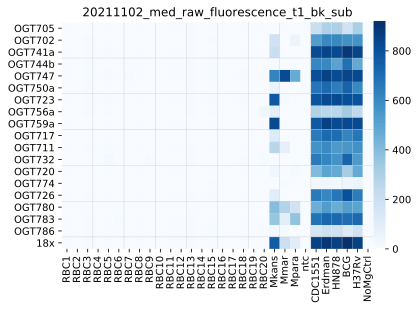

In [50]:
# stat_fl_sum = list(stat_fl.sum(axis=1))
# stat_fl = stat_fl.divide(stat_fl_sum,axis='rows')
median_diff = median_t1

# median_diff = median_diff.rename(index={"crRNA1": "IS6110_1", "crRNA2": "IS6110_2", "crRNA3": "IS1081_1", \
#                           "crRNA4": "IS1081_2", "crRNA5": "IS6110_3", "crRNA6": "IS1081_3", \
#                            "crRNA7": "IS1081_4", "crRNA8": "IS1081_5", "crRNA9": "IS1081_6", \
#                            "crRNA10": "IS6110_4", "crRNA11": "IS6110_5", "crRNA12": "IS1081_7", \
#                           "crRNA13": "IS6110_6", "crRNA14": "IS6110_7", "crRNA15": "IS1081_8",  \
#                           "crRNA16": "IS6110_8", "crRNA17": "IS6110_9", "crRNA18": "J IS6110_10", \
#                           "crRNA19": "Pool_18"})
control_column = median_diff['T30']
median_diff = median_diff.sub(control_column,axis=0)
median_diff = median_diff.clip(0)

plot_heatmap(median_diff,exp_string,'med_raw_fluorescence_t1_bk_sub',0) 
# median_diff
count_thresh = median_diff[median_diff > 100].count()
labels = [f"{i}" for i in count_thresh]

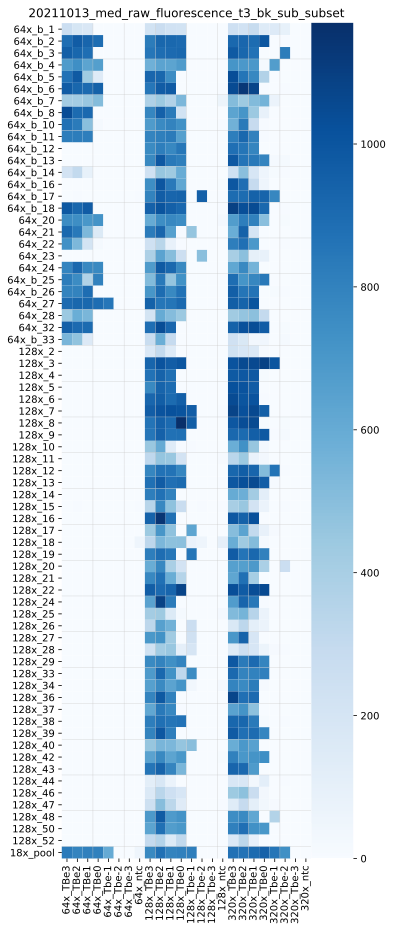

In [24]:
# stat_fl_sum = list(stat_fl.sum(axis=1))
# stat_fl = stat_fl.divide(stat_fl_sum,axis='rows')
median_diff = median_diff.drop(['crRNA9','crRNA15','crRNA19',\
                                'crRNA29','crRNA30','crRNA31','crRNA34',\
                                'crRNA56','crRNA63','crRNA64'\
                               ,'crRNA65','crRNA68','crRNA74','crRNA78'\
                               ,'crRNA82','crRNA84'], axis=0)
plot_heatmap(median_diff,exp_string,'med_raw_fluorescence_t3_bk_sub_subset',0) 


# median_diff
count_thresh = median_diff[median_diff > 100].count()
labels = [f"{i}" for i in count_thresh]

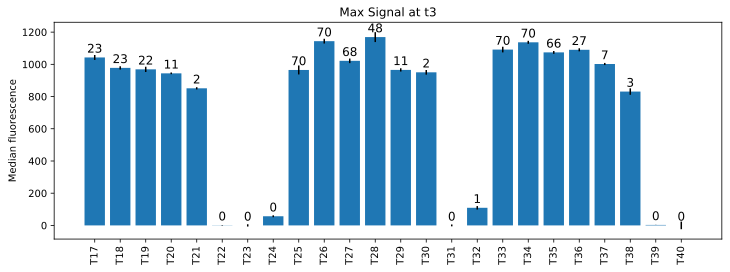

In [26]:
positions = targets
positions = positions[:40]
# positions = ['T18', 'T19', 'T20', 'T4', 'T6', 'T7', 'T8', 'T9', 'T10']

# xlabels = ['e4', 'e3', 'e2', 'e1', 'e0', 'e-1', 'e-2', 'NTC']
xlabels = positions#['1e4', '1e3', '1e2', '1e1', '1e0','1e-1', '1e-2', 'ntc']
title_string = 'Max Signal at t3'

median_diff = median_diff
max_signals = median_diff.max(axis=0)
max_signals_id = median_diff.idxmax(axis=0)
serror = stdev_t3.lookup(max_signals_id[positions].values, positions) \
        /num_fl.lookup(max_signals_id[positions].values, positions)
plt.figure(figsize=(12,4))
plt.bar(x=xlabels, height=max_signals.loc[positions], \
        yerr = serror, )
plt.title(title_string)
def addlabels(x,y,s):
    for i in range(len(x)):
        plt.text(i,y[i]+30,s[i],ha = 'center', fontsize=12)
  
    
addlabels(xlabels,max_signals.loc[positions],labels)

# plt.xlabel('Genome equivalents per reaction')
plt.ylabel('Median fluorescence')
plt.xticks(rotation=90) 
plt.savefig(figures_folder+exp_string+title_string+'.png',\
                dpi=300, bbox_inches='tight')   